# task 1

## метод Ньютона с выбором шага и с одномерным поиском (любым методом);

In [2]:
import numpy as np
import tqdm

from abc import ABC, abstractmethod

import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [3]:
class Function(ABC):
    """
    Abstract base class representing a mathematical function and its gradient.

    Subclasses must implement both the function evaluation (`fun`)
    and its gradient calculation (`grad`).

    Methods
    -------
    fun(x: np.ndarray) -> float
        Compute the function value at point x
    grad(x: np.ndarray) -> np.ndarray
        Compute the gradient of the function at point x
    hessian(x: np.ndarray) -> np.matrix
        Compute the hessian of the function at point x
    """
    def __init__(self):
        self.stat = FunctionStat()

    @abstractmethod
    def _fun(self, x: np.ndarray) -> float:
        pass

    @abstractmethod
    def _grad(self, x: np.ndarray) -> np.ndarray:
        pass

    @abstractmethod
    def _hessian(self, x: np.ndarray) -> np.matrix:
        pass

    def fun(self, x: np.ndarray) -> float:
        self.stat.fun_inc()
        return self._fun(x)

    def grad(self, x: np.ndarray) -> np.ndarray:
        self.stat.grad_inc()
        return self._grad(x)

    def hessian(self, x: np.ndarray) -> np.ndarray:
        self.stat.hessian_inc()
        return self._hessian(x)

    def __str__(self):
        return str(self.stat)

class FunctionStat:
    def __init__(self):
        self.fun_count = 0
        self.grad_count = 0
        self.hessian_count = 0

    def __str__(self):
        return f"fun countre {self.fun_count}\ngrad countre {self.grad_count}\nhessian countre {self.hessian_count}"

    def fun_inc(self):
        self.fun_count += 1

    def grad_inc(self):
        self.grad_count += 1

    def hessian_inc(self):
        self.hessian_count += 1

In [4]:
class GradientDescent(ABC):
    """
    Abstract base class representing a gradient descent algorithm.
    Subclasses must implement both the gradient descent algorithm
    and its gradient calculation (`grad`).

    Parameters
    ----------
    max_iterations : int, optional
        Maximum number of iterations (default: 10000)
    eps : float, optional
        Convergence threshold for stopping criterion (default: 1e-6)


    Methods
    -------
    fit(start: np.ndarray, function: Function) -> np.ndarray
        run algorithm for `start` point of `function`
    """
    def __init__(self, max_iterations : int = 10000, eps: float = 1e-6):
        self.max_iterations = max_iterations
        self.eps = eps

    def fit(self, start : np.ndarray, function : Function) -> (np.ndarray, int):
        """
        Run gradient descent optimization algorithm

        Parameters
        ----------
        start : np.ndarray
            Initial starting point of shape (n,), where n is the problem dimension
        function : Function
            Objective function implementing both `fun` and `grad` methods

        Returns
        -------
        np.ndarray
            Optimized parameters array of shape (n, 2)
        int
            Number of iterations

        Raises
        ------
        ValueError
            If input dimensions mismatch or function is not properly defined
        """
        x = start
        path = np.array([x])
        iter = self.max_iterations

        for i in tqdm.tqdm(range(1, self.max_iterations + 1)):
            grad = function.grad(x).flatten()
            hessian = function.hessian(x)
            reversed_hessian = reverse_hessian(hessian)
            step = reversed_hessian @ grad
            step = np.array(step)[0]
            x_next = x - self.next_step(fun=function, step=step, x=x)
            if self.norm_step(x_next, grad):
                iter = i
                break
            x = x_next
            path = np.vstack((path, x))
        return path, iter

    @abstractmethod
    def next_step(self, fun : Function, step : np.ndarray, x : np.ndarray) -> np.ndarray:
        pass

    def norm_step(self, x, y : np.ndarray) -> bool:
        """
        Run gradient descent optimization algorithm

        Parameters
        ----------
        x, y : np.ndarray
            two points of shape (n,) where n is the problem dimension

        Returns
        -------
        bool
            true if distance between x and y is less than self.eps
        """
        return np.linalg.norm(x - y) < self.eps

# Реализация метода ньютона

### Вспомогательные функции

In [5]:
def reverse_hessian(hessian : np.ndarray) -> np.ndarray:
    """
        Parameters
        ----------
        hessian : np.ndarray
            hessian of shape (n,n) where n is the problem dimension

        Returns
        -------
        np.ndarray
            reverse hessian of shape (n,n) where n is the problem dimension
    """
    try:
        rv = np.linalg.inv(hessian)
    except np.linalg.LinAlgError:
        rv = np.linalg.pinv(hessian)
    return rv


## Реализация классического метода ньютона

In [6]:
class ClassicNewton(GradientDescent):
    """
        class representing a classical Newton algorithm.
    """
    def __init__(self, max_iterations : int = 10000, eps : float = 1e-6):
        super().__init__(max_iterations, eps)

    def next_step(self, fun : Function, step : np.ndarray, x : np.ndarray) -> np.ndarray:
        return step

# Реализация демпфированного метода ньютона

In [7]:
class LineSearch(ABC):
    @abstractmethod
    def search(self,
               x : np.ndarray,
               step : np.ndarray,
               grad:np.ndarray,
               function:Function,
               prev_alpha : float) -> float:
        pass

In [8]:
class ArmijoSearch(LineSearch):
    def __init__(self, const : float = 1e-4, rho : float = 0.5, eps : float = 1e-10):
        self.const = const
        self.rho = rho
        self.eps = eps

    def _condition(self, x : np.ndarray,
                 grad : np.ndarray,
                 function : Function,
                 alpha : float,
                 step : np.ndarray) -> bool:
        x_new = x - alpha * step
        f_new = function.fun(x_new)
        f_cur = function.fun(x)
        grad_dot_step = np.dot(grad, step)
        return f_new <= f_cur + self.const * alpha * grad_dot_step

    def search(self,
               x : np.ndarray,
               step : np.ndarray,
               grad:np.ndarray,
               function:Function,
               prev_alpha : float) -> float:
        alpha = prev_alpha
        while not self._condition(x=x, grad=grad, step=step, function=function, alpha=alpha):
            alpha *= self.rho
            if alpha < self.eps:
                break
        return alpha

In [9]:
class DempNewton(GradientDescent):
    """
        class representing a Newton with line search step algorithm.
    """
    def __init__(self, line_searcher : LineSearch = ArmijoSearch(), max_iterations : int = 10000, eps : float = 1e-6):
        super().__init__(max_iterations, eps)
        self.alpha = 1
        self.line_searcher = line_searcher


    def next_step(self, fun : Function, step : np.ndarray, x : np.ndarray) -> np.ndarray:
        grad = fun.grad(x)
        self.alpha = self.line_searcher.search(x=x,
                                       function=fun,
                                       step=step,
                                       grad=grad,
                                       prev_alpha=self.alpha)
        return step * self.alpha

## Квазиньютовские методы


## scipy.optimize: метод Newton-CG и один-два квазиньютоновских метода.

In [44]:
class QuasiNewton(GradientDescent, ABC):
    def __init__(self, max_iterations : int = 10000, eps : float = 1e-6):
        super().__init__(max_iterations, eps)

    def next_step(self, fun : Function, step : np.ndarray, x : np.ndarray) -> np.ndarray:
        return -step @ fun.grad(x)


    @abstractmethod
    def aprox_hess(self,
                   x_next : np.ndarray,
                   x_prev : np.ndarray,
                   prevHess : np.ndarray,
                   fun : Function) -> np.ndarray:
        pass

    def fit(self, start: np.ndarray, function: Function) -> (np.ndarray, int):
        x = np.copy(start)
        path = [x.copy()]
        hess = np.eye(len(x))
        iter_count = self.max_iterations

        for i in tqdm.tqdm(range(1, self.max_iterations + 1)):
            grad = function.grad(x)
            if np.linalg.norm(grad) < self.eps:
                iter_count = i
                break

            p = self.next_step(function, hess, x)
            x_next = x + p
            hess = self.aprox_hess(x_next, x, hess, function)
            x = x_next.copy()
            path.append(x.copy())

        return np.array(path), iter_count

In [35]:
class DFP(QuasiNewton):
    def __init__(self, max_iterations : int = 10000, eps : float = 1e-6):
        super().__init__(max_iterations, eps)

    def aprox_hess(self,
                   x_next : np.ndarray,
                   x_prev : np.ndarray,
                   prevHess : np.ndarray,
                   fun : Function) -> np.ndarray:
        yk = fun.grad(x_next) - fun.grad(x_prev)
        sk = x_next - x_prev

        Hy = prevHess @ yk
        term1 = (Hy.reshape(-1, 1) @ Hy.reshape(1, -1)) / (yk @ Hy)
        term2 = (sk.reshape(-1, 1) @ sk.reshape(1, -1)) / (yk @ sk)

        return prevHess - term1 + term2

In [36]:
class BFGS(QuasiNewton):
    def __init__(self, max_iterations : int = 10000, eps : float = 1e-6):
        super().__init__(max_iterations, eps)

    def aprox_hess(self,
                   x_next : np.ndarray,
                   x_prev : np.ndarray,
                   prevHess : np.ndarray,
                   fun : Function) -> np.ndarray:
        yk = fun.grad(x_next) - fun.grad(x_prev)
        sk = x_next - x_prev

        rho = 1.0 / (yk @ sk)
        I = np.eye(len(sk))
        A = I - rho * sk.reshape(-1, 1) @ yk.reshape(1, -1)
        B = I - rho * yk.reshape(-1, 1) @ sk.reshape(1, -1)
        term1 = A @ prevHess @ B
        term2 = rho * (sk.reshape(-1, 1) @ sk.reshape(1, -1))

        return term1 + term2


### Scipy NEwton

In [13]:
class ScipyNewton(GradientDescent):
    def __init__(self, max_iterations : int = 10000, eps : float = 1e-6):
        super().__init__(max_iterations, eps)

    def fit(self, start : np.ndarray, function : Function) -> (np.ndarray, int):
        return minimize(fun=function.fun, x0=start, method="Newton-CG",
                        jac=function.grad, hess=function.hessian,)

    def next_step(self, fun : Function, step : np.ndarray, x : np.ndarray) -> np.ndarray:
        pass

## Введение функций со сложным поведением

In [14]:
class Rastrigin(Function):
    def _fun(self, xy : np.ndarray) -> float:
        x, y = xy
        return  20 + (x**2 - 10*np.cos(2*np.pi*x)) + (y**2 - 10*np.cos(2*np.pi*y))

    def _grad(self, xy : np.ndarray) -> np.ndarray:
        x, y = xy
        return np.array([
            2*x + 20*np.pi*np.sin(2*np.pi*x),
            2*y + 20*np.pi*np.sin(2*np.pi*y)
        ])

    def _hessian(self, xy : np.ndarray) -> np.matrix:
        x, y = xy
        def f(x : float) -> float:
            return 2 + 40*np.cos(2*np.pi*x)
        return np.matrix([
            [f(x), 0],
            [0, f(y)]
        ])

In [15]:
class Rosenbrock(Function):
    def _fun(self, xy : np.ndarray) -> float:
        x, y = xy
        return (1 - x)**2 + 100 * (y - x**2)**2

    def _grad(self, xy : np.ndarray) -> np.ndarray:
        x, y = xy
        return np.array([-2*(1 - x) - 400*x*(y - x**2),200*(y - x**2)])

    def _hessian(self, xy: np.ndarray) -> np.matrix:
        x, y = xy
        return np.matrix([
            [2 - 400*(y-3*x**2), -400*x],
            [-400*x, 200]
        ])

In [41]:
class CoolFunc(Function):
    def _fun(self, xy : np.ndarray) -> float:
        x, y = xy
        return x**2 - 10*y**2
    def _grad(self, xy : np.ndarray) -> np.ndarray:
        x, y = xy
        return np.array([2*x, -20*y])
    def _hessian(self, xy: np.ndarray) -> np.matrix:
        x, y = xy
        return np.matrix([
            [2, 0],
            [0, -20]
        ])

## Визуализатор

In [120]:
def visualize_gradient(f, path, x_bounds=(-2, 2), y_bounds=(-2, 2), title="Gradient Descent Path", max_deviation=2.0):
    """
    Визуализирует путь градиентного спуска с фильтрацией аномальных точек.

    Parameters:
    -----------
    f : callable
        Целевая функция (принимает [x,y], возвращает скаляр)
    path : np.ndarray
        Массив точек пути формы (n_points, 2)
    x_bounds : tuple
        Границы области визуализации по X (x_min, x_max)
    y_bounds : tuple
        Границы области визуализации по Y (y_min, y_max)
    title : str
        Заголовок графиков
    max_deviation : float
        Максимальное допустимое отклонение от границ (в единицах области визуализации)
    """
    assert path.ndim == 2 and path.shape[1] == 2, "Path must be of shape (n_points, 2)"
    assert x_bounds[0] < x_bounds[1], "x_bounds must be (x_min, x_max)"
    assert y_bounds[0] < y_bounds[1], "y_bounds must be (y_min, y_max)"

    x_min, x_max = x_bounds
    y_min, y_max = y_bounds

    x_valid_min = x_min - max_deviation*(x_max - x_min)
    x_valid_max = x_max + max_deviation*(x_max - x_min)
    y_valid_min = y_min - max_deviation*(y_max - y_min)
    y_valid_max = y_max + max_deviation*(y_max - y_min)

    valid_mask = (
        (path[:, 0] >= x_valid_min) &
        (path[:, 0] <= x_valid_max) &
        (path[:, 1] >= y_valid_min) &
        (path[:, 1] <= y_valid_max)
    )

    filtered_path = path[valid_mask]

    if len(filtered_path) == 0:
        raise ValueError("All points are outside valid bounds! Adjust max_deviation or check your optimization path.")

    x = np.linspace(x_min, x_max, 100)
    y = np.linspace(y_min, y_max, 100)
    X, Y = np.meshgrid(x, y)

    try:
        Z = f([X, Y])
    except:
        Z = np.array([[f([xi, yi]) for xi in x] for yi in y])

    plt.figure(figsize=(15, 6))

    ax1 = plt.subplot(1, 2, 1, projection='3d')
    ax1.plot_surface(X, Y, Z, cmap='viridis', alpha=0.6)
    ax1.plot(
        filtered_path[:, 0],
        filtered_path[:, 1],
        [f(p) for p in filtered_path],
        'r.-', linewidth=2, markersize=8, label='Optimization Path'
    )

    ax2 = plt.subplot(1, 2, 2)
    contour = ax2.contour(X, Y, Z, levels=20, cmap='viridis')
    ax2.clabel(contour, inline=True, fontsize=8)
    ax2.plot(
        filtered_path[:, 0],
        filtered_path[:, 1],
        'r.-', linewidth=2, markersize=8, label='Optimization Path'
    )

    for ax in [ax1, ax2]:
        ax.scatter(
            filtered_path[0, 0], filtered_path[0, 1],
            s=100, c='green', marker='o', label='Start'
        )
        ax.scatter(
            filtered_path[-1, 0], filtered_path[-1, 1],
            s=100, c='blue', marker='x', label='End'
        )
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

    n_filtered = len(path) - len(filtered_path)
    if n_filtered > 0:
        print(f"Фильтрация: удалено {n_filtered} точек за пределами области")
        print(f"Оставшиеся точки: {len(filtered_path)} из {len(path)}")

## Тестирование на функции растригина

In [121]:
r_start = np.array([0.5, 0.5])

In [122]:
def test_newton(
        method : GradientDescent,
        start : np.ndarray,
        f : str):
    if f == 'Rastrigin':
        f = Rastrigin()
    elif f == 'Rosenbrock':
        f = Rosenbrock()
    else:
        return

    path, _ = method.fit(start, f)
    print(f)

def vizualize_newton(
        method : GradientDescent,
        start : np.ndarray,
        f : str):
    if f == 'Rastrigin':
        f = Rastrigin()
    elif f == 'Rosenbrock':
        f = Rosenbrock()
    elif f == 'Cool':
        f = CoolFunc()
    else:
        return
    path, _ = method.fit(start, f)
    visualize_gradient(f=lambda x : f.fun(x), path=path, x_bounds=(-3,3),y_bounds=(-3,3))

### Тестирование на функции розенбурга

In [123]:
r_start=np.array([0.5, 0.5])
test_newton(ClassicNewton(), start=r_start, f='Rosenbrock')
test_newton(DempNewton(), start=r_start, f='Rosenbrock')
test_newton(DFP(), start=r_start, f='Rosenbrock')
test_newton(BFGS(), start=r_start, f='Rosenbrock')

100%|██████████| 10000/10000 [00:00<00:00, 18853.24it/s]


fun countre 0
grad countre 10000
hessian countre 10000


100%|██████████| 10000/10000 [00:00<00:00, 17007.67it/s]


fun countre 20010
grad countre 20000
hessian countre 10000
fun countre 0
grad countre 40000
hessian countre 0
fun countre 0
grad countre 205
hessian countre 0


100%|██████████| 10000/10000 [00:00<00:00, 19164.55it/s]


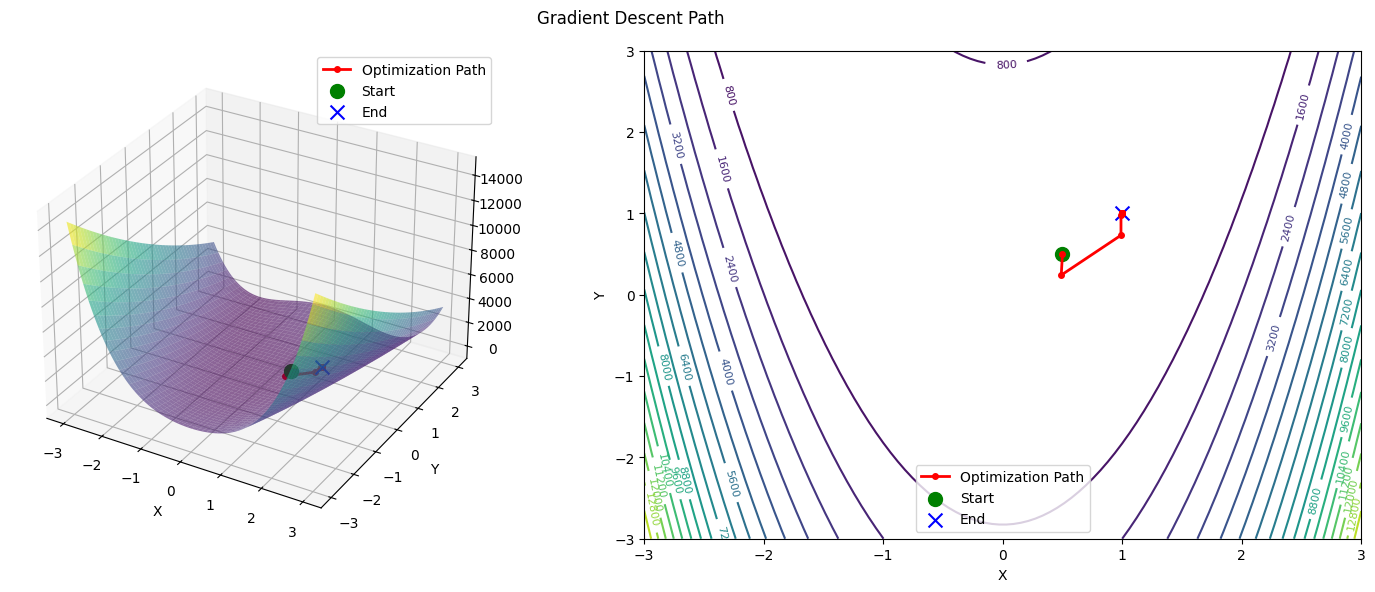

In [124]:
vizualize_newton(ClassicNewton(), start=r_start, f='Rosenbrock')

100%|██████████| 10000/10000 [00:00<00:00, 16702.28it/s]


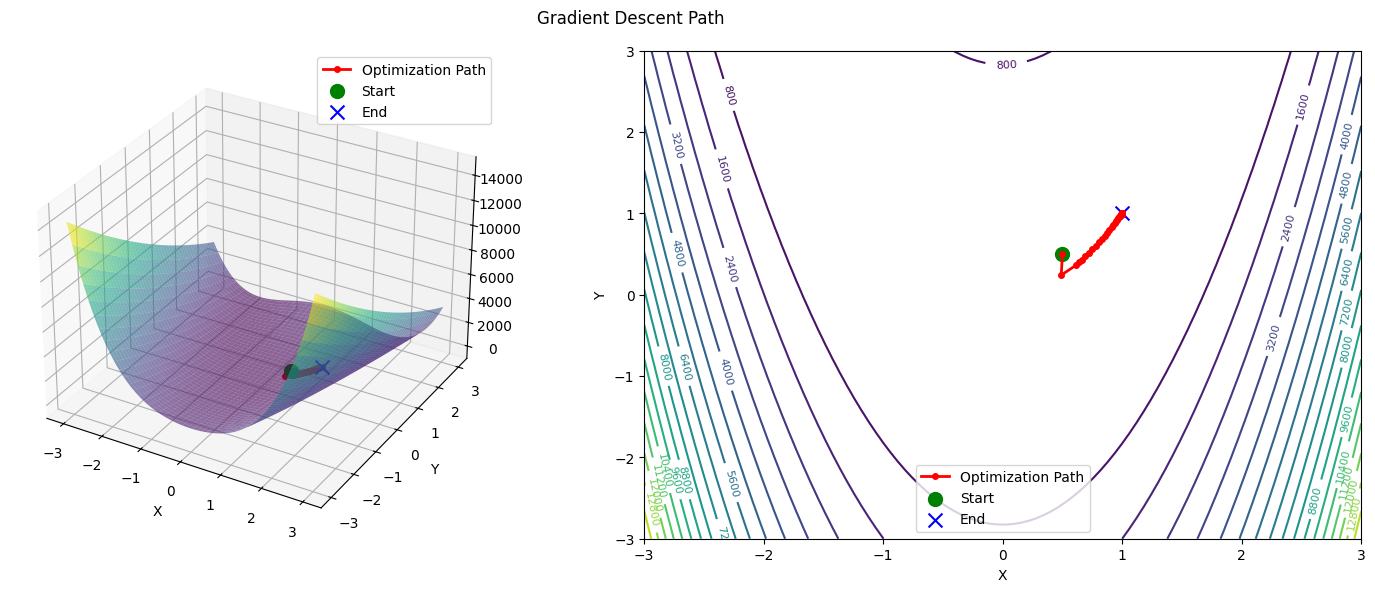

In [125]:
vizualize_newton(DempNewton(), start=r_start, f='Rosenbrock')

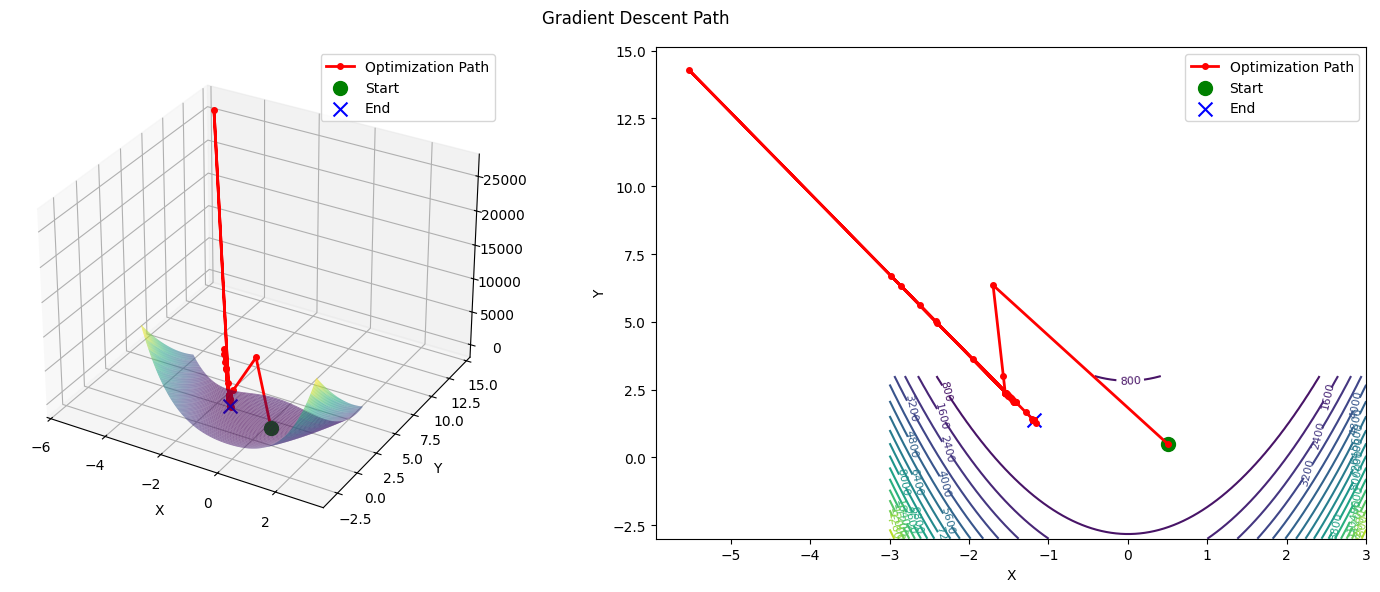

Фильтрация: удалено 265 точек за пределами области
Оставшиеся точки: 9736 из 10001


In [126]:
vizualize_newton(DFP(), start=r_start, f='Rosenbrock')

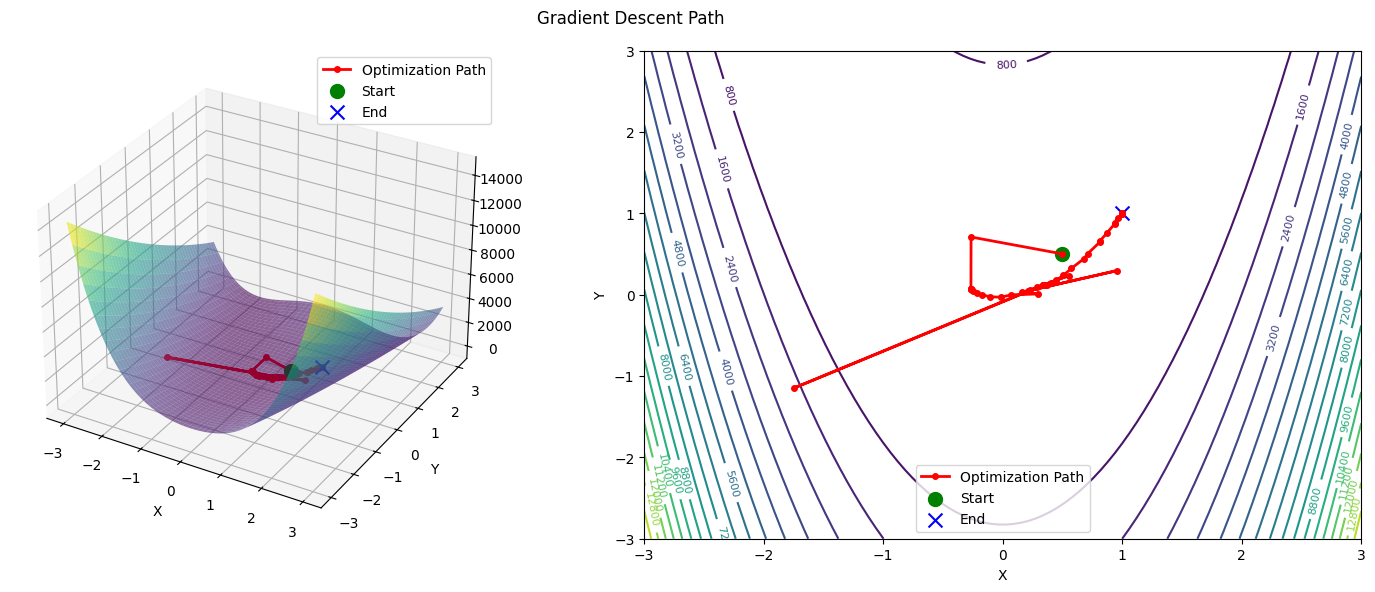

Фильтрация: удалено 5 точек за пределами области
Оставшиеся точки: 47 из 52


In [127]:
vizualize_newton(BFGS(), start=r_start, f='Rosenbrock')

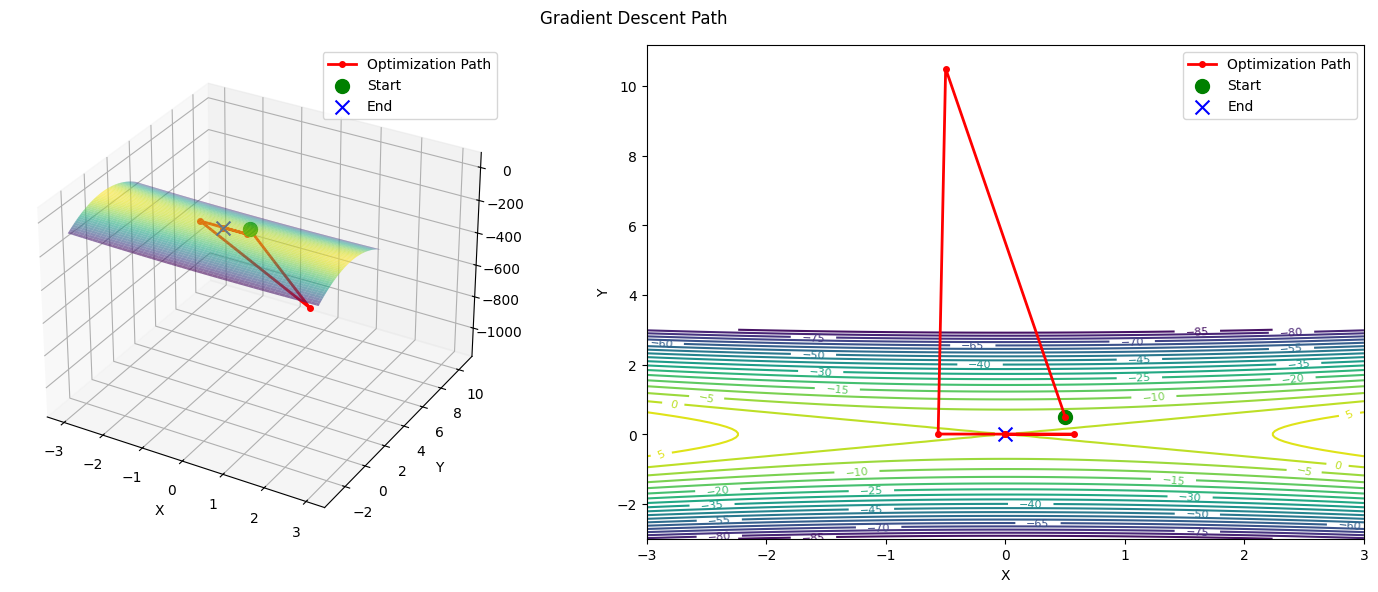

In [128]:
vizualize_newton(BFGS(), start=r_start, f='Cool')

In [129]:
ScipyNewton().fit(r_start, Rosenbrock())

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 1.6830877701268957e-11
       x: [ 1.000e+00  1.000e+00]
     nit: 26
     jac: [ 4.456e-04 -2.265e-04]
    nfev: 34
    njev: 34
    nhev: 26

In [130]:
import matplotlib.patches as patches
from matplotlib.path import Path

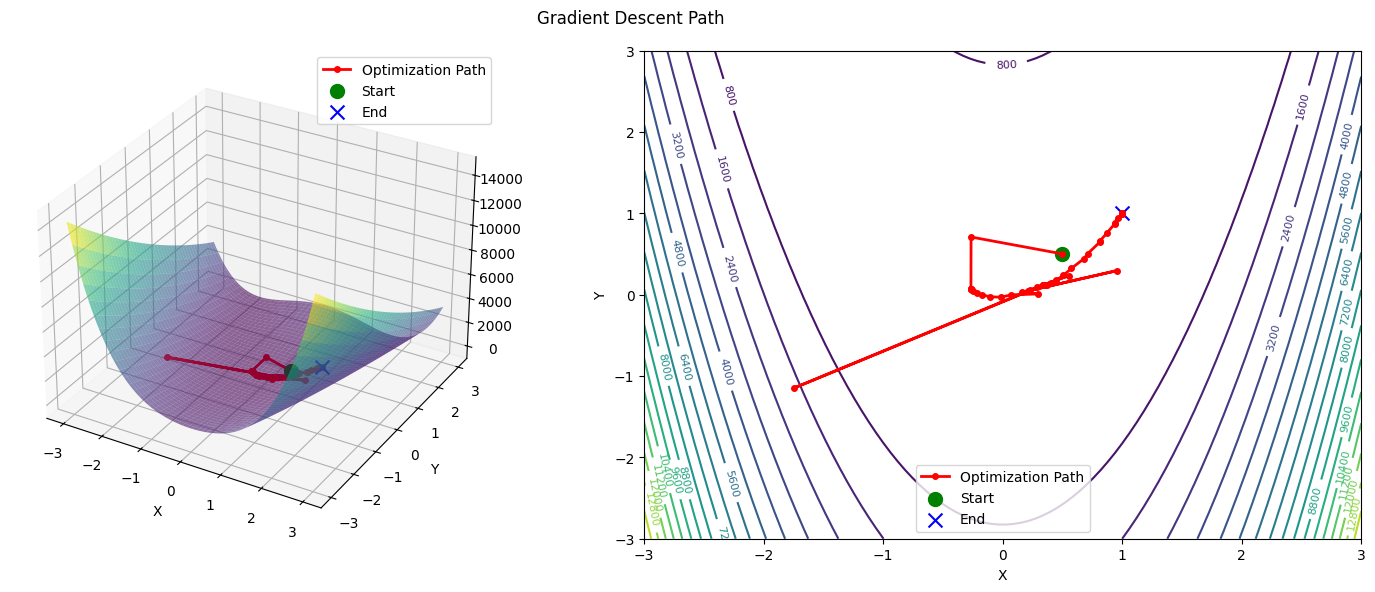

Фильтрация: удалено 5 точек за пределами области
Оставшиеся точки: 47 из 52


In [131]:
vizualize_newton(BFGS(),r_start,f='Rosenbrock')